# Machine Learning for Text Classification
### Using SpaCy

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
import nltk
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

df = pd.read_csv('https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/research_paper.csv')
df.head()

[nltk_data] Downloading package stopwords to /Users/MPHA/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS


## Check for missing values

In [4]:
df.isnull().sum()

Title         0
Conference    0
dtype: int64

## Split data into Training and Test sets

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.33, random_state=42)

print('Research Title Sample:', train['Title'].iloc[0])
print('Conference of this Paper:', train['Conference'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Research Title Sample: Cooperating with Smartness: Using Heterogeneous Smart Antennas in Ad-Hoc Networks.
Conference of this Paper: INFOCOM
Training Data Shape: (1679, 2)
Testing Data Shape: (828, 2)


#### There are 2507 Research Paper Titles - Classified into 5 Categories (by Conference)
## Visually summarize the distribution 

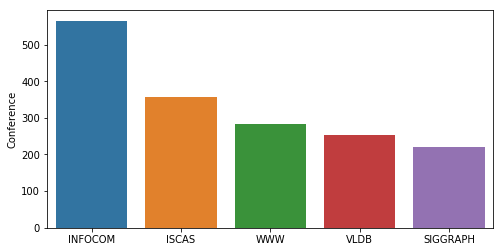

In [6]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train['Conference'].unique(),
           y = train['Conference'].value_counts())
plt.show()

## Text Preprocessing with spaCy
#### Find the Top Words Used - in papers submitted to the 1st and 2nd Categories

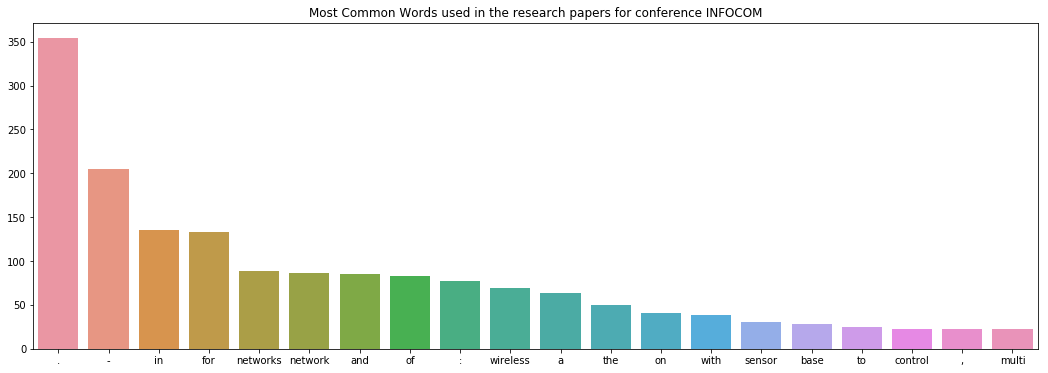

In [7]:
import spacy

nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print('Processed %d out of %d documents.' % (coujnter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

INFO_text = [text for text in train[train['Conference'] == 'INFOCOM']['Title']]

IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()

IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()

INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)

INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the research papers for conference INFOCOM')
plt.show()

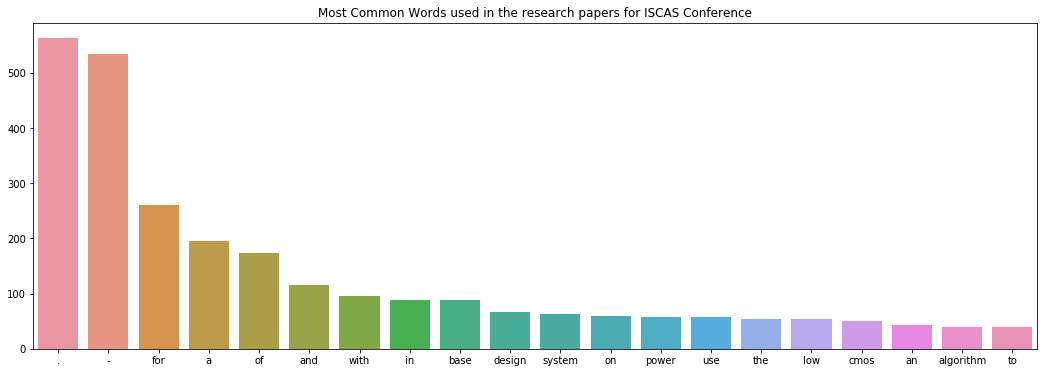

In [8]:
IS_common_words = [word[0] for word in IS_counts.most_common(20)]
IS_common_counts = [word[1] for word in IS_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=IS_common_words, y=IS_common_counts)
plt.title('Most Common Words used in the research papers for ISCAS Conference')
plt.show()

#### INFOCOM top words - 'networks' and 'network' - suggests a conference about various networks
#### ISCAS top words - 'base' and 'design' - suggests a conference on databases, or system design

## Machine Learning with spaCy

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score

spacy.load('en')
from spacy.lang.en import English
from spacy.lang.en import STOP_WORDS
from nltk.corpus import stopwords

parser = English()

#### An additional way to clean text with spaCy - stopwords must be re-imported

In [19]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self

def get_params(self, deep=True):
    return {}

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

#### Define a Function to print the Most Important Features (having the highest coefficients)

In [21]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N+1):-1]
    print('Class 1 Best: ')
    for feat in topClass1:
        print(feat)
    print('Class 2 best: ')
    for feat in topClass2:
        print(feat)
    
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()),
                 ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['Title'].tolist()
labelsTrain1 = train['Conference'].tolist()

test1 = test['Title'].tolist()
labelsTest1 = test['Conference'].tolist()

# train
pipe.fit(train1, labelsTrain1)

# test
preds = pipe.predict(test1)

print('Accuracy:', accuracy_score(labelsTest1, preds))
print('Top 10 Features used to Predict: ')

printNMostInformative(vectorizer, clf, 10)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)

vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ''
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

Accuracy: 0.7439613526570048
Top 10 Features used to Predict: 
Class 1 Best: 
(-0.9288669375088513, 'database')
(-0.8483561901502177, 'chip')
(-0.7690666142244298, 'wimax')
(-0.6917847637690714, 'object')
(-0.6729398115131606, 'functional')
(-0.6623375017965389, 'multihop')
(-0.6400363210103148, 'amplifier')
(-0.6388413127964091, 'chaotic')
(-0.6174035554167069, 'receiver')
(-0.602661797731073, 'web')
Class 2 best: 
(1.1833672934521369, 'speccast')
(1.0741896223128575, 'manets')
(0.9501956323184437, 'gossip')
(0.8469683056403198, 'node')
(0.8460150822269066, 'packet')
(0.8341764854436224, 'schedule')
(0.8336539510642647, 'queue')
(0.8270047370591307, 'multicast')
(0.8252248486921077, 'qos')
(0.8178628885624322, 'location')


In [22]:
from sklearn import metrics
print(metrics.classification_report(labelsTest1, preds, target_names=df['Conference'].unique()))

             precision    recall  f1-score   support

       VLDB       0.75      0.77      0.76       159
      ISCAS       0.91      0.83      0.87       299
   SIGGRAPH       0.67      0.66      0.66       106
    INFOCOM       0.61      0.69      0.65       139
        WWW       0.62      0.62      0.62       125

avg / total       0.75      0.74      0.75       828

